In [142]:
index_year = "2024"
excluded_hs2 = ["27", "71", "98", "99"]

# Standard libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from pathlib import Path

output_dir = Path("data-output")
output_dir.mkdir(exist_ok=True)

In [143]:
df = pd.read_parquet("data/TOTAldata-current.parquet")

# Create HS code hierarchy columns
df["HS6"] = df["I_COMMODITY"].str[0:6]
df["HS4"] = df["I_COMMODITY"].str[0:4]
df["HS2"] = df["I_COMMODITY"].str[0:2]
# HS8 level (must create column first)
df["HS8"] = df["I_COMMODITY"].str[0:8]
df["HS10"] = df["I_COMMODITY"]

# Convert time to datetime
df.time = pd.to_datetime(df.time, format="%Y-%m")

# Convert numeric columns to float
df["CON_VAL_MO"] = df["CON_VAL_MO"].astype(float)
df["CAL_DUT_MO"] = df["CAL_DUT_MO"].astype(float)

In [144]:
df.dtypes

CTY_NAME                     object
CON_VAL_MO                  float64
CAL_DUT_MO                  float64
I_COMMODITY                  object
I_COMMODITY_SDESC            object
time                 datetime64[ns]
COMM_LVL                     object
HS6                          object
HS4                          object
HS2                          object
HS8                          object
HS10                         object
dtype: object

In [145]:
df.tail()

,CTY_NAME,CON_VAL_MO,CAL_DUT_MO,I_COMMODITY,I_COMMODITY_SDESC,time,COMM_LVL,HS6,HS4,HS2,HS8,HS10
2691215,TOTAL FOR ALL COUNTRIES,2.992000e+03,0.0,9817004600,"SOUND AND VISUAL RECORDINGS, TAPES & SIMILAR A...",2025-11-01,HS10,981700,9817,98,98170046,9817004600
2691216,TOTAL FOR ALL COUNTRIES,0.000000e+00,0.0,9817004800,PATTERNS/WALL CHARTS; GLOBES; MOCK-UPS/VISUALS...,2025-11-01,HS10,981700,9817,98,98170048,9817004800
2691217,TOTAL FOR ALL COUNTRIES,2.543048e+08,511013.0,9817005000,"AGRICULTURAL/HORTICULTURAL MACH,EQUIP&IMPLEMENTS",2025-11-01,HS10,981700,9817,98,98170050,9817005000
2691218,TOTAL FOR ALL COUNTRIES,1.797788e+08,343598.0,9817006000,"PTS USED IN ARTICLES IN 8432,8433,8434& 8436",2025-11-01,HS10,981700,9817,98,98170060,9817006000
2691219,TOTAL FOR ALL COUNTRIES,2.820306e+09,0.0,9999950000,ESTIMATED IMPORTS OF LOW VALUED TRANSACTIONS,2025-11-01,HS10,999995,9999,99,99999500,9999950000


In [146]:
dfenduse = pd.read_parquet("data/hs6-enduse.parquet")

dfenduse["ENDUSE"] = dfenduse["BEC5EndUse"]

dfenduse["HS6"] = dfenduse["HS6"].astype(str)

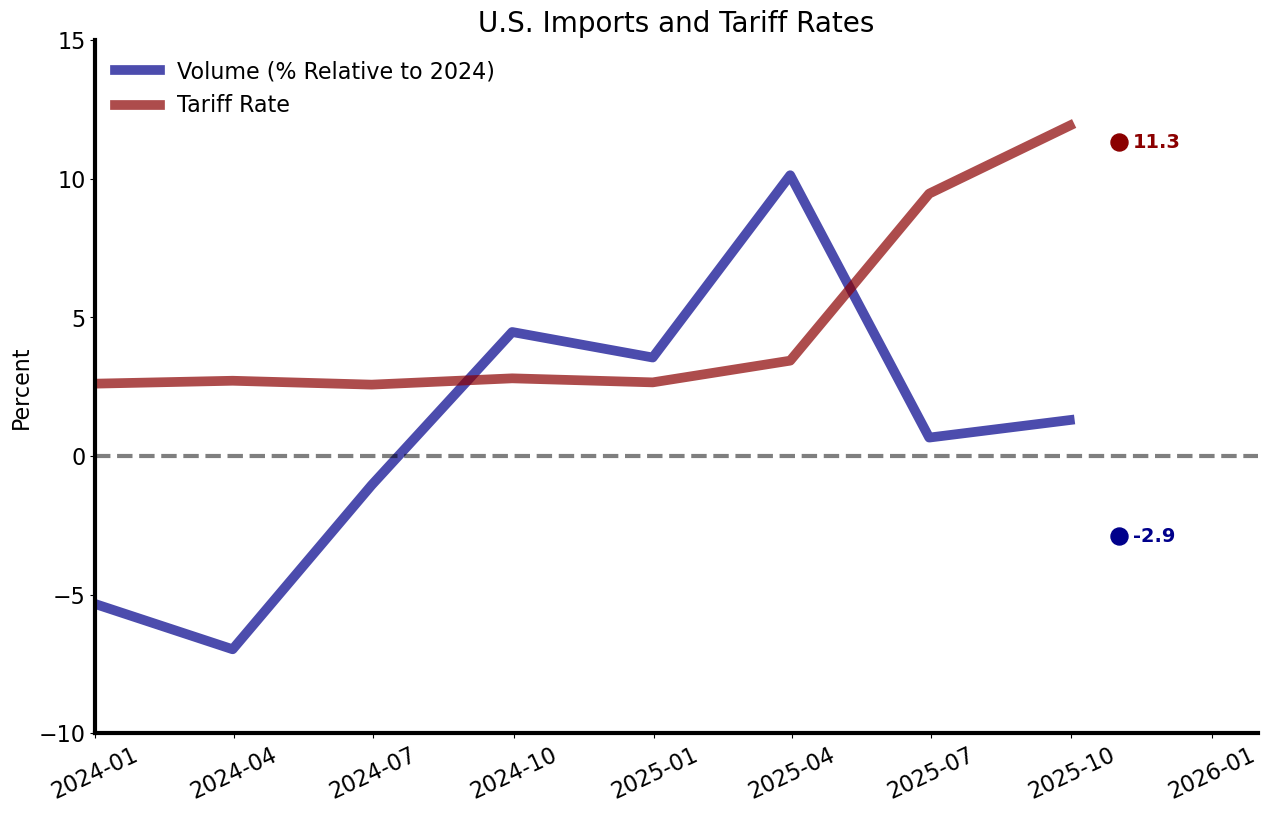

In [147]:
dfsec = df[~df["HS2"].isin(excluded_hs2)]

dfsec_monthly = dfsec.groupby("time").agg({"CON_VAL_MO": "sum", "CAL_DUT_MO": "sum"}).reset_index()

dfsec_monthly["tariff"] = 100 * dfsec_monthly["CAL_DUT_MO"] / dfsec_monthly["CON_VAL_MO"]

dfsec_monthly.set_index("time", inplace=True)

dfsec_quarterly = dfsec.set_index('time').resample('QE').agg({
    'CON_VAL_MO': 'sum',
    'CAL_DUT_MO': 'sum'
})
dfsec_quarterly['tariff'] = 100 * dfsec_quarterly['CAL_DUT_MO'] / dfsec_quarterly['CON_VAL_MO']

grp = dfsec_quarterly.groupby("time")

sec_trade = grp.agg({"CON_VAL_MO": "sum", "CAL_DUT_MO": "sum"}).reset_index()

sec_trade["tariff"] = 100 * sec_trade["CAL_DUT_MO"] / sec_trade["CON_VAL_MO"]

sec_trade.set_index("time", inplace=True)

#####################################################################################

fig, ax = plt.subplots(figsize = (15,9))

# Create second y-axis
# ax2 = ax.twinx()

# Separate complete quarters from incomplete last quarter
sec_trade_complete = sec_trade.iloc[:-1]
sec_trade_last = sec_trade.iloc[-1]

# Plot volume on left axis (complete quarters)
ax.plot(sec_trade_complete.index, 100*(4*sec_trade_complete["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum() - 1) , 
        color = "darkblue", alpha = 0.7, linewidth = 7, label="Volume (% Relative to 2024)")

# Plot November 2025 monthly observation as a dot
november_data = dfsec_monthly[(dfsec_monthly.index.year == 2025) & (dfsec_monthly.index.month == 11)].iloc[-1]
november_date = november_data.name
november_volume = 100*(12*november_data["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum() - 1)
ax.scatter(
    [november_date],
    [november_volume],
    color="darkblue", s=150, zorder=5
)

# Plot tariff on right axis (complete quarters)
ax.plot(sec_trade_complete.index, sec_trade_complete["tariff"] , 
        color = "darkred", alpha = 0.7, linewidth = 7, label="Tariff Rate")

# Plot November 2025 monthly tariff observation as a dot
november_tariff = november_data["tariff"]
ax.scatter(
    [november_date],
    [november_tariff],
    color="darkred", s=150, zorder=5
)

# Add annotations for November observations
ax.annotate(
    f'{november_volume:.1f}',
    xy=(november_date, november_volume),
    xytext=(10, 0), textcoords='offset points',
    fontsize=14, fontweight='bold', color='darkblue',
    va='center'
)

ax.annotate(
    f'{november_tariff:.1f}',
    xy=(november_date, november_tariff),
    xytext=(10, 0), textcoords='offset points',
    fontsize=14, fontweight='bold', color='darkred',
    va='center'
)

ax.set_title("U.S. Imports and Tariff Rates", fontsize = 20)

ax.set_xlim([dt.datetime(2024,1,1), dt.datetime(2026,1,31)])

ax.axhline(y=0, color='black', linestyle='--', linewidth=3, alpha=0.5)

# ax2.axhline(y=sec_trade["tariff"].loc[index_year].mean(), color='darkred', linestyle='--', linewidth=3, alpha=0.5)

ax.set_ylim(-10,15)
# ax2.set_ylim(0,15)  # Adjust as needed for tariff scale

ax.tick_params(axis='x', labelsize=16, rotation=25)
ax.tick_params(axis='y', labelsize=16)
# ax2.tick_params(axis='y', labelsize=16)

ax.set_ylabel("Percent", fontsize=16)
# ax2.set_ylabel("Tariff Rate (%)", fontsize=16, color="darkred")



ax.legend(loc='upper left', fontsize=16, frameon=False)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)
# ax2.spines["top"].set_visible(False)
# ax2.spines["right"].set_linewidth(3)

# # Color the y-axis labels to match the lines
# ax.tick_params(axis='y', colors='darkblue')

quarterly_export = sec_trade_complete.copy()
quarterly_export = quarterly_export[["CON_VAL_MO", "tariff"]]
quarterly_export.index.name = "time"
quarterly_export.to_csv(output_dir / "us_imports_quarterly.csv")

monthly_export = dfsec_monthly.copy()
monthly_export = monthly_export[["CON_VAL_MO", "tariff"]]
monthly_export.index.name = "time"
monthly_export.to_csv(output_dir / "us_imports_monthly.csv")

plt.show()


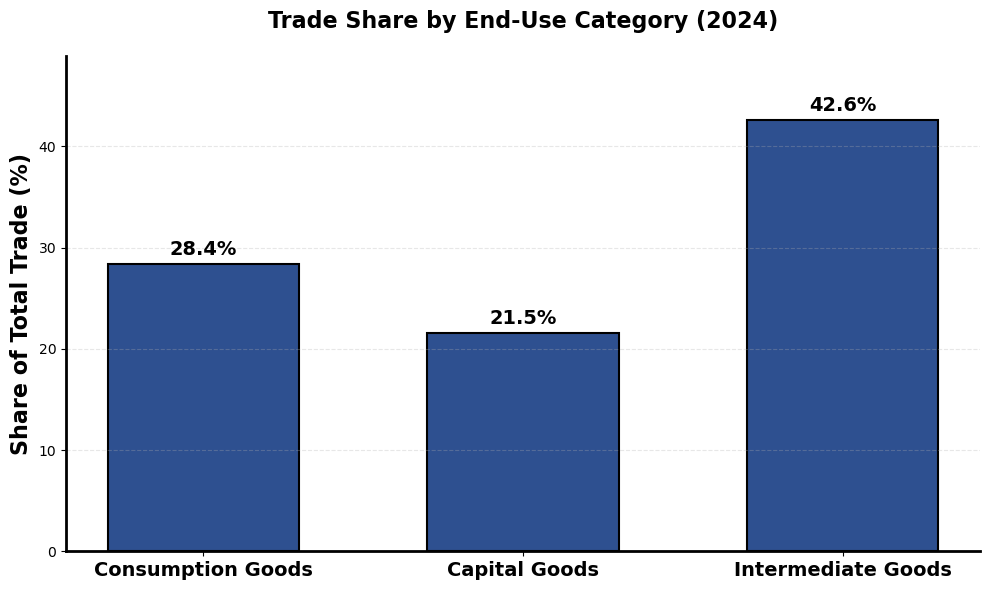


Trade Shares in 2024:
  Consumption Goods: 28.4%
  Capital Goods: 21.5%
  Intermediate Goods: 42.6%
  Total: 92.5%


In [148]:
# Trade share by end-use category
base_year = 2024  # Can change this to any year

df_filtered = df[~df["HS2"].isin(excluded_hs2)]

# Filter for the base year
df_year = df_filtered[df_filtered["time"].dt.year == base_year]

# Calculate total trade for the year
total_trade = df_year["CON_VAL_MO"].sum()

# Calculate trade by end-use category
categories = ["CONS", "CAP", "INT"]
trade_shares = []
category_labels = ["Consumption Goods", "Capital Goods", "Intermediate Goods"]

for cat in categories:
    cat_hs6 = dfenduse[dfenduse["ENDUSE"] == cat]["HS6"].unique()
    cat_trade = df_year[df_year["HS6"].isin(cat_hs6)]["CON_VAL_MO"].sum()
    share = (cat_trade / total_trade) * 100
    trade_shares.append(share)

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(category_labels, trade_shares, color='#2E5090', edgecolor='black', linewidth=1.5, width=0.6)

# Add value labels on bars
for i, (label, share) in enumerate(zip(category_labels, trade_shares)):
    ax.text(i, share + 0.5, f'{share:.1f}%', 
            ha='center', va='bottom', fontsize=14, fontweight='bold')

# Formatting
ax.set_ylabel('Share of Total Trade (%)', fontsize=16, fontweight='bold')
ax.set_title(f'Trade Share by End-Use Category ({base_year})', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(0, max(trade_shares) * 1.15)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Make x-tick labels bold and larger
ax.tick_params(axis='x', labelsize=14)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)

plt.tight_layout()
plt.show()

print(f"\nTrade Shares in {base_year}:")
for label, share in zip(category_labels, trade_shares):
    print(f"  {label}: {share:.1f}%")
print(f"  Total: {sum(trade_shares):.1f}%")

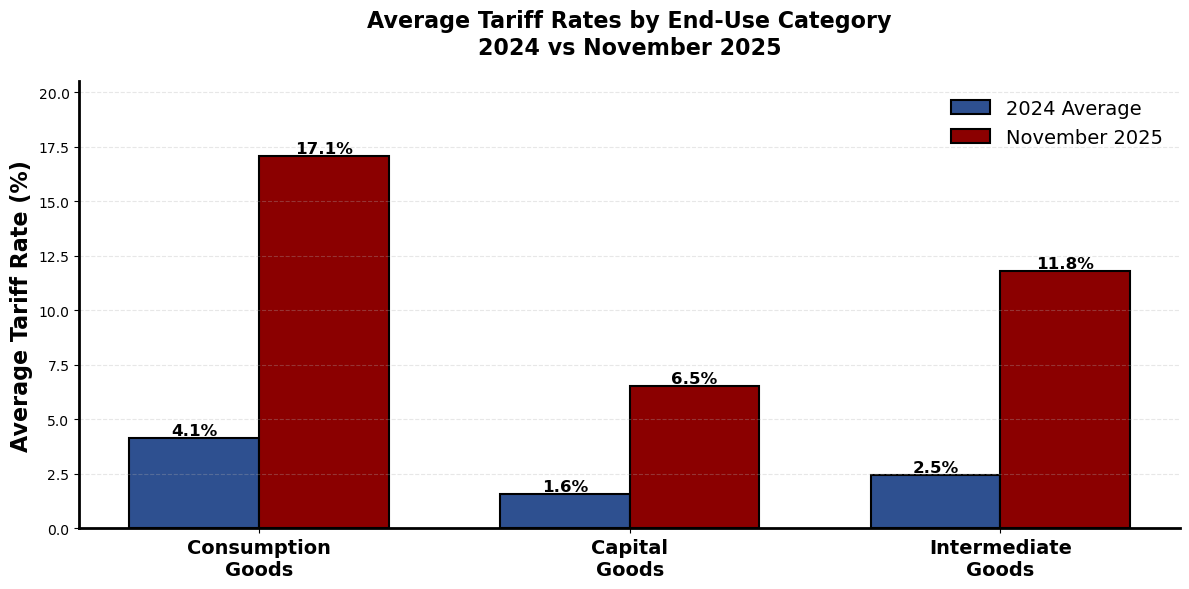


Average Tariff Rates:
  Consumption Goods:
    2024 Average: 4.12%
    November 2025: 17.09%
    Change: 12.96 percentage points
  Capital Goods:
    2024 Average: 1.56%
    November 2025: 6.55%
    Change: 4.99 percentage points
  Intermediate Goods:
    2024 Average: 2.46%
    November 2025: 11.78%
    Change: 9.32 percentage points


In [149]:
# Average tariff rates by end-use category: 2024 vs November 2025
df_filtered = df[~df["HS2"].isin(excluded_hs2)]

# Calculate tariff rates for 2024 and November 2025
categories = ["CONS", "CAP", "INT"]
category_labels = ["Consumption\nGoods", "Capital\nGoods", "Intermediate\nGoods"]
tariff_2024 = []
tariff_nov2025 = []

for cat in categories:
    cat_hs6 = dfenduse[dfenduse["ENDUSE"] == cat]["HS6"].unique()
    df_cat = df_filtered[df_filtered["HS6"].isin(cat_hs6)]
    
    # 2024 average tariff
    df_2024 = df_cat[df_cat["time"].dt.year == 2024]
    tariff_rate_2024 = 100 * df_2024["CAL_DUT_MO"].sum() / df_2024["CON_VAL_MO"].sum()
    tariff_2024.append(tariff_rate_2024)
    
    # November 2025 tariff
    df_nov2025 = df_cat[(df_cat["time"].dt.year == 2025) & (df_cat["time"].dt.month == 11)]
    tariff_rate_nov2025 = 100 * df_nov2025["CAL_DUT_MO"].sum() / df_nov2025["CON_VAL_MO"].sum()
    tariff_nov2025.append(tariff_rate_nov2025)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(category_labels))
width = 0.35

bars1 = ax.bar(x - width/2, tariff_2024, width, label='2024 Average', 
               color='#2E5090', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, tariff_nov2025, width, label='November 2025',
               color='darkred', edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Formatting
ax.set_ylabel('Average Tariff Rate (%)', fontsize=16, fontweight='bold')
ax.set_title('Average Tariff Rates by End-Use Category\n2024 vs November 2025', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(category_labels)
ax.legend(fontsize=14, frameon=False, loc='upper right')
ax.set_ylim(0, max(max(tariff_2024), max(tariff_nov2025)) * 1.2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Make x-tick labels bold and larger
ax.tick_params(axis='x', labelsize=14)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)

plt.tight_layout()
plt.show()

print(f"\nAverage Tariff Rates:")
for label, t2024, tnov2025 in zip(["Consumption Goods", "Capital Goods", "Intermediate Goods"], 
                                   tariff_2024, tariff_nov2025):
    print(f"  {label}:")
    print(f"    2024 Average: {t2024:.2f}%")
    print(f"    November 2025: {tnov2025:.2f}%")
    print(f"    Change: {tnov2025 - t2024:.2f} percentage points")

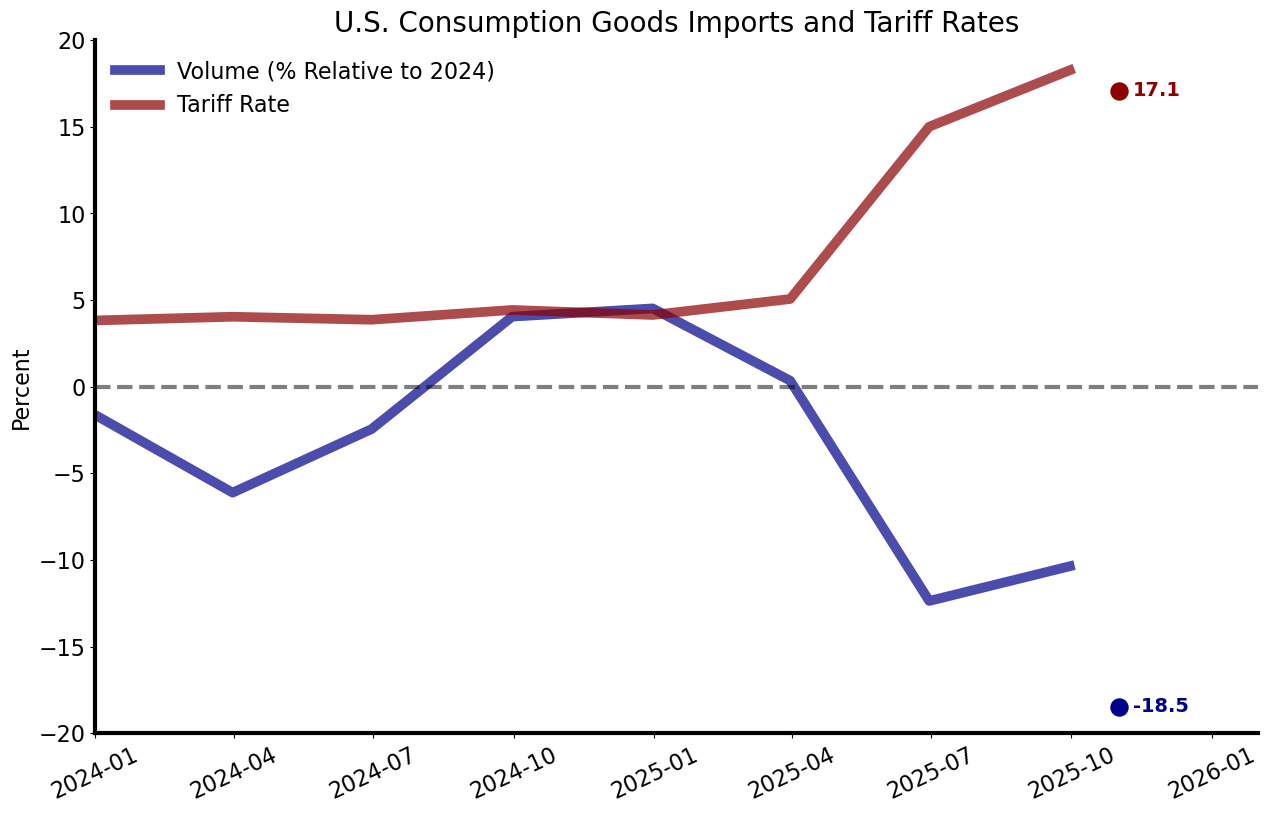

In [150]:
dfsec = df[~df["HS2"].isin(excluded_hs2)]

dfsec = dfsec[dfsec["HS6"].isin(dfenduse[dfenduse["ENDUSE"] == "CONS"]["HS6"].unique())]

dfsec_monthly = dfsec.groupby("time").agg({"CON_VAL_MO": "sum", "CAL_DUT_MO": "sum"}).reset_index()
dfsec_monthly["tariff"] = 100 * dfsec_monthly["CAL_DUT_MO"] / dfsec_monthly["CON_VAL_MO"]
dfsec_monthly.set_index("time", inplace=True)

dfsec_quarterly = dfsec.set_index('time').resample('QE').agg({
    'CON_VAL_MO': 'sum',
    'CAL_DUT_MO': 'sum'
})
dfsec_quarterly['tariff'] = 100 * dfsec_quarterly['CAL_DUT_MO'] / dfsec_quarterly['CON_VAL_MO']

grp = dfsec_quarterly.groupby("time")

sec_trade = grp.agg({"CON_VAL_MO": "sum", "CAL_DUT_MO": "sum"}).reset_index()

sec_trade["tariff"] = 100 * sec_trade["CAL_DUT_MO"] / sec_trade["CON_VAL_MO"]

sec_trade.set_index("time", inplace=True)

#####################################################################################

fig, ax = plt.subplots(figsize = (15,9))

# Create second y-axis
# ax2 = ax.twinx()

# Separate complete quarters from incomplete last quarter
sec_trade_complete = sec_trade.iloc[:-1]

# Plot volume on left axis (complete quarters)
ax.plot(sec_trade_complete.index, 100*(4*sec_trade_complete["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum() - 1) , 
        color = "darkblue", alpha = 0.7, linewidth = 7, label="Volume (% Relative to 2024)")

# Plot November 2025 monthly observation as a dot
november_data = dfsec_monthly[(dfsec_monthly.index.year == 2025) & (dfsec_monthly.index.month == 11)].iloc[-1]
november_date = november_data.name
november_volume = 100*(12*november_data["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum() - 1)
ax.scatter(
    [november_date],
    [november_volume],
    color="darkblue", s=150, zorder=5
)

# Plot tariff on right axis (complete quarters)
ax.plot(sec_trade_complete.index, sec_trade_complete["tariff"] , 
        color = "darkred", alpha = 0.7, linewidth = 7, label="Tariff Rate")

# Plot November 2025 monthly tariff observation as a dot
november_tariff = november_data["tariff"]
ax.scatter(
    [november_date],
    [november_tariff],
    color="darkred", s=150, zorder=5
)

# Add annotations for November observations
ax.annotate(
    f'{november_volume:.1f}',
    xy=(november_date, november_volume),
    xytext=(10, 0), textcoords='offset points',
    fontsize=14, fontweight='bold', color='darkblue',
    va='center'
)

ax.annotate(
    f'{november_tariff:.1f}',
    xy=(november_date, november_tariff),
    xytext=(10, 0), textcoords='offset points',
    fontsize=14, fontweight='bold', color='darkred',
    va='center'
)

ax.set_title("U.S. Consumption Goods Imports and Tariff Rates", fontsize = 20)

ax.set_xlim([dt.datetime(2024,1,1), dt.datetime(2026,1,31)])

ax.axhline(y=0, color='black', linestyle='--', linewidth=3, alpha=0.5)

# ax2.axhline(y=sec_trade["tariff"].loc[index_year].mean(), color='darkred', linestyle='--', linewidth=3, alpha=0.5)

ax.set_ylim(-20,20)
# ax2.set_ylim(0,20)  # Adjust as needed for tariff scale

ax.tick_params(axis='x', labelsize=16, rotation=25)
ax.tick_params(axis='y', labelsize=16)
# ax2.tick_params(axis='y', labelsize=16)

# ax2.tick_params(axis='y', colors='darkred')

ax.set_ylabel("Percent", fontsize=16)
# ax.tick_params(axis='y', colors='darkblue')

# ax2.set_ylabel("Tariff Rate (%)", fontsize=16, color="darkred")# Color the y-axis labels to match the lines


ax.legend(loc='upper left', fontsize=16, frameon=False)
# ax2.spines["right"].set_linewidth(3)

# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.spines["top"].set_visible(False)

# ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=16, frameon=False)
ax.spines["bottom"].set_linewidth(3)

ax.spines["left"].set_linewidth(3)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

quarterly_export = sec_trade_complete.copy()
quarterly_export = quarterly_export[["CON_VAL_MO", "tariff"]]
quarterly_export.index.name = "time"
quarterly_export.to_csv(output_dir / "consumption_goods_quarterly.csv")

monthly_export = dfsec_monthly.copy()
monthly_export = monthly_export[["CON_VAL_MO", "tariff"]]
monthly_export.index.name = "time"
monthly_export.to_csv(output_dir / "consumption_goods_monthly.csv")

plt.show()

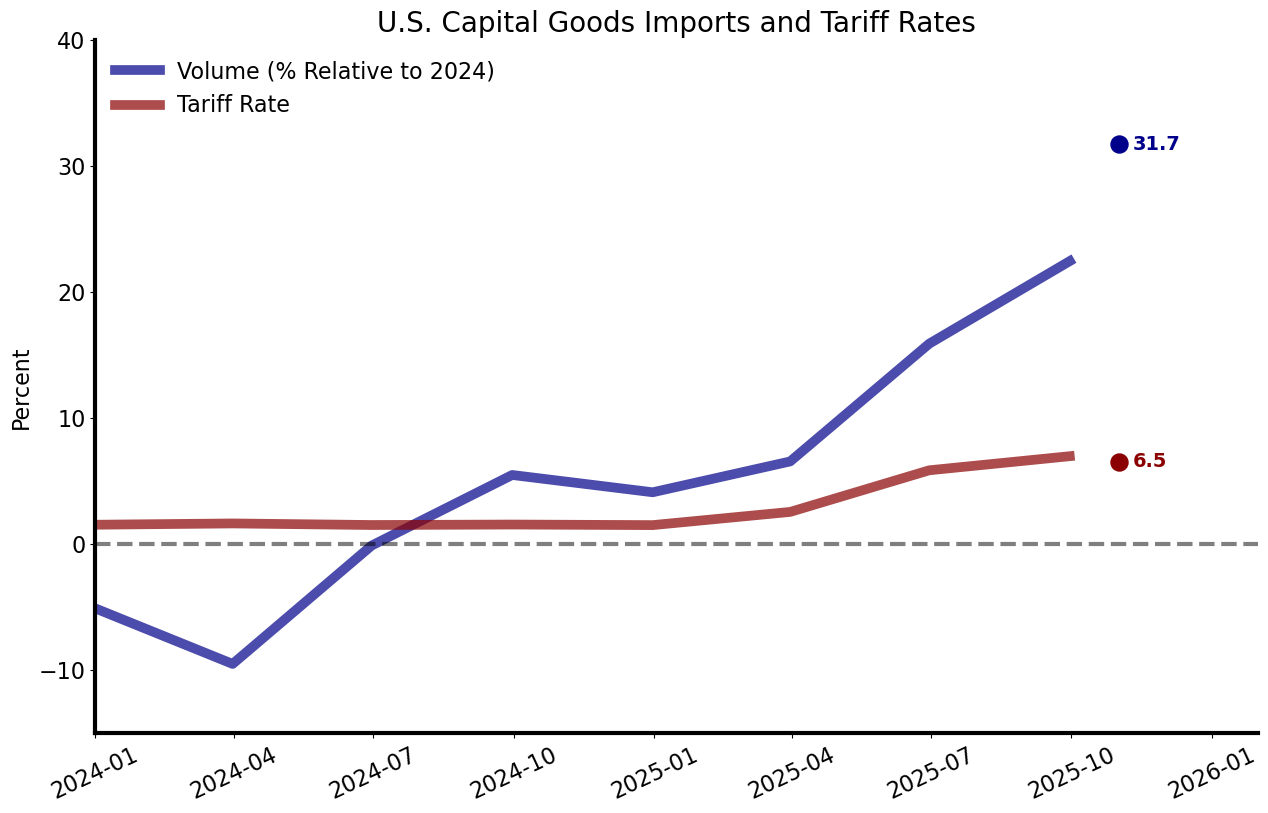

In [151]:
dfsec = df[~df["HS2"].isin(excluded_hs2)]

dfsec = dfsec[dfsec["HS6"].isin(dfenduse[dfenduse["ENDUSE"] == "CAP"]["HS6"].unique())]

dfsec_monthly = dfsec.groupby("time").agg({"CON_VAL_MO": "sum", "CAL_DUT_MO": "sum"}).reset_index()
dfsec_monthly["tariff"] = 100 * dfsec_monthly["CAL_DUT_MO"] / dfsec_monthly["CON_VAL_MO"]
dfsec_monthly.set_index("time", inplace=True)

dfsec_quarterly = dfsec.set_index('time').resample('QE').agg({
    'CON_VAL_MO': 'sum',
    'CAL_DUT_MO': 'sum'
})
dfsec_quarterly['tariff'] = 100 * dfsec_quarterly['CAL_DUT_MO'] / dfsec_quarterly['CON_VAL_MO']

grp = dfsec_quarterly.groupby("time")

sec_trade = grp.agg({"CON_VAL_MO": "sum", "CAL_DUT_MO": "sum"}).reset_index()

sec_trade["tariff"] = 100 * sec_trade["CAL_DUT_MO"] / sec_trade["CON_VAL_MO"]

sec_trade.set_index("time", inplace=True)

#####################################################################################

fig, ax = plt.subplots(figsize = (15,9))

# Create second y-axis
# ax2 = ax.twinx()

# Separate complete quarters from incomplete last quarter
sec_trade_complete = sec_trade.iloc[:-1]

# Plot volume on left axis (complete quarters)
ax.plot(sec_trade_complete.index, 100*(4*sec_trade_complete["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum() - 1) , 
        color = "darkblue", alpha = 0.7, linewidth = 7, label="Volume (% Relative to 2024)")

# Plot November 2025 monthly observation as a dot
november_data = dfsec_monthly[(dfsec_monthly.index.year == 2025) & (dfsec_monthly.index.month == 11)].iloc[-1]
november_date = november_data.name
november_volume = 100*(12*november_data["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum() - 1)
ax.scatter(
    [november_date],
    [november_volume],
    color="darkblue", s=150, zorder=5
)

# Plot tariff on right axis (complete quarters)
ax.plot(sec_trade_complete.index, sec_trade_complete["tariff"] , 
        color = "darkred", alpha = 0.7, linewidth = 7, label="Tariff Rate")

# Plot November 2025 monthly tariff observation as a dot
november_tariff = november_data["tariff"]
ax.scatter(
    [november_date],
    [november_tariff],
    color="darkred", s=150, zorder=5
)

# Add annotations for November observations
ax.annotate(
    f'{november_volume:.1f}',
    xy=(november_date, november_volume),
    xytext=(10, 0), textcoords='offset points',
    fontsize=14, fontweight='bold', color='darkblue',
    va='center'
)

ax.annotate(
    f'{november_tariff:.1f}',
    xy=(november_date, november_tariff),
    xytext=(10, 0), textcoords='offset points',
    fontsize=14, fontweight='bold', color='darkred',
    va='center'
)

ax.set_title("U.S. Capital Goods Imports and Tariff Rates", fontsize = 20)

ax.set_xlim([dt.datetime(2024,1,1), dt.datetime(2026,1,31)])

ax.axhline(y=0, color='black', linestyle='--', linewidth=3, alpha=0.5)

# ax2.axhline(y=sec_trade["tariff"].loc[index_year].mean(), color='darkred', linestyle='--', linewidth=3, alpha=0.5)

ax.set_ylim(-15,40)
# ax2.set_ylim(0,25)  # Adjust as needed for tariff scale

ax.tick_params(axis='x', labelsize=16, rotation=25)
ax.tick_params(axis='y', labelsize=16)
# ax2.tick_params(axis='y', labelsize=16)

ax.set_ylabel("Percent", fontsize=16)
# ax2.set_ylabel("Tariff Rate (%)", fontsize=16, color="darkred")



ax.legend(loc='upper left', fontsize=16, frameon=False)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)
# ax2.spines["top"].set_visible(False)
# ax2.spines["right"].set_linewidth(3)

# # Color the y-axis labels to match the lines
# ax.tick_params(axis='y', colors='darkblue')

quarterly_export = sec_trade_complete.copy()
quarterly_export = quarterly_export[["CON_VAL_MO", "tariff"]]
quarterly_export.index.name = "time"
quarterly_export.to_csv(output_dir / "capital_goods_quarterly.csv")

monthly_export = dfsec_monthly.copy()
monthly_export = monthly_export[["CON_VAL_MO", "tariff"]]
monthly_export.index.name = "time"
monthly_export.to_csv(output_dir / "capital_goods_monthly.csv")

plt.show()


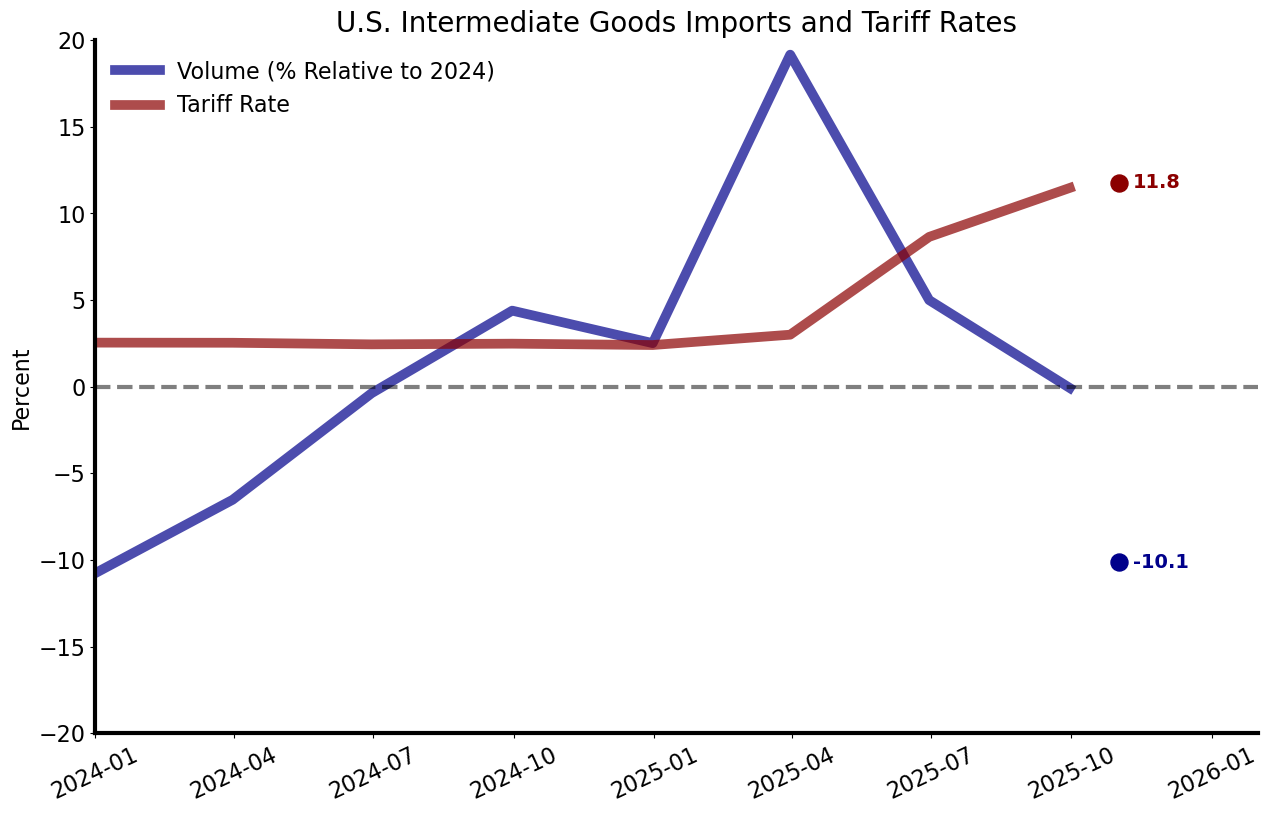

In [152]:
dfsec = df[~df["HS2"].isin(excluded_hs2)]

dfsec = dfsec[dfsec["HS6"].isin(dfenduse[dfenduse["ENDUSE"] == "INT"]["HS6"].unique())]

dfsec_monthly = dfsec.groupby("time").agg({"CON_VAL_MO": "sum", "CAL_DUT_MO": "sum"}).reset_index()
dfsec_monthly["tariff"] = 100 * dfsec_monthly["CAL_DUT_MO"] / dfsec_monthly["CON_VAL_MO"]
dfsec_monthly.set_index("time", inplace=True)

dfsec_quarterly = dfsec.set_index('time').resample('QE').agg({
    'CON_VAL_MO': 'sum',
    'CAL_DUT_MO': 'sum'
})
dfsec_quarterly['tariff'] = 100 * dfsec_quarterly['CAL_DUT_MO'] / dfsec_quarterly['CON_VAL_MO']

grp = dfsec_quarterly.groupby("time")

sec_trade = grp.agg({"CON_VAL_MO": "sum", "CAL_DUT_MO": "sum"}).reset_index()

sec_trade["tariff"] = 100 * sec_trade["CAL_DUT_MO"] / sec_trade["CON_VAL_MO"]

sec_trade.set_index("time", inplace=True)

#####################################################################################

fig, ax = plt.subplots(figsize = (15,9))

# Create second y-axis
# ax2 = ax.twinx()

# Separate complete quarters from incomplete last quarter
sec_trade_complete = sec_trade.iloc[:-1]

# Plot volume on left axis (complete quarters)
ax.plot(sec_trade_complete.index, 100*(4*sec_trade_complete["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum() - 1) , 
        color = "darkblue", alpha = 0.7, linewidth = 7, label="Volume (% Relative to 2024)")

# Plot November 2025 monthly observation as a dot
november_data = dfsec_monthly[(dfsec_monthly.index.year == 2025) & (dfsec_monthly.index.month == 11)].iloc[-1]
november_date = november_data.name
november_volume = 100*(12*november_data["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum() - 1)
ax.scatter(
    [november_date],
    [november_volume],
    color="darkblue", s=150, zorder=5
)

# Plot tariff on right axis (complete quarters)
ax.plot(sec_trade_complete.index, sec_trade_complete["tariff"] , 
        color = "darkred", alpha = 0.7, linewidth = 7, label="Tariff Rate")

# Plot November 2025 monthly tariff observation as a dot
november_tariff = november_data["tariff"]
ax.scatter(
    [november_date],
    [november_tariff],
    color="darkred", s=150, zorder=5
)

# Add annotations for November observations
ax.annotate(
    f'{november_volume:.1f}',
    xy=(november_date, november_volume),
    xytext=(10, 0), textcoords='offset points',
    fontsize=14, fontweight='bold', color='darkblue',
    va='center'
)

ax.annotate(
    f'{november_tariff:.1f}',
    xy=(november_date, november_tariff),
    xytext=(10, 0), textcoords='offset points',
    fontsize=14, fontweight='bold', color='darkred',
    va='center'
)

ax.set_title("U.S. Intermediate Goods Imports and Tariff Rates", fontsize = 20)

ax.set_xlim([dt.datetime(2024,1,1), dt.datetime(2026,1,31)])

ax.axhline(y=0, color='black', linestyle='--', linewidth=3, alpha=0.5)

# ax2.axhline(y=sec_trade["tariff"].loc[index_year].mean(), color='darkred', linestyle='--', linewidth=3, alpha=0.5)

ax.set_ylim(-20,20)
# ax2.set_ylim(0,20)  # Adjust as needed for tariff scale

ax.tick_params(axis='x', labelsize=16, rotation=25)
ax.tick_params(axis='y', labelsize=16)
# ax2.tick_params(axis='y', labelsize=16)

# ax2.tick_params(axis='y', colors='darkred')

ax.set_ylabel("Percent", fontsize=16)
# ax.tick_params(axis='y', colors='darkblue')

# ax2.set_ylabel("Tariff Rate (%)", fontsize=16, color="darkred")# Color the y-axis labels to match the lines



ax.legend(loc='upper left', fontsize=16, frameon=False)
# ax2.spines["right"].set_linewidth(3)

# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.spines["top"].set_visible(False)

# ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=16, frameon=False)
ax.spines["bottom"].set_linewidth(3)

ax.spines["left"].set_linewidth(3)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

quarterly_export = sec_trade_complete.copy()
quarterly_export = quarterly_export[["CON_VAL_MO", "tariff"]]
quarterly_export.index.name = "time"
quarterly_export.to_csv(output_dir / "intermediate_goods_quarterly.csv")

monthly_export = dfsec_monthly.copy()
monthly_export = monthly_export[["CON_VAL_MO", "tariff"]]
monthly_export.index.name = "time"
monthly_export.to_csv(output_dir / "intermediate_goods_monthly.csv")

plt.show()

In [153]:
matlist = pd.read_csv('c:\\github\\ai-trade-index\\hs10_classification_final.csv')

# matlist = pd.read_csv('hs10_datacenter_relevance.csv')

# Convert to category
matlist['relevance'] = matlist['relevance'].astype('category')

# Or specify order if needed (e.g., for sorting/comparisons)
matlist['relevance'] = pd.Categorical(
    matlist['relevance'], 
    categories=['Low', 'Medium', 'High'], 
    ordered=True
)

matlist.rename(columns={'hs10_code': 'HS10'}, inplace=True)

# matlist["HS10"] = matlist["HS10"].astype(str)

In [154]:
df["HS10"] = df["HS10"].astype(int)

# Merge Relevance category from matlist onto df
df = df.merge(matlist[['HS10', 'relevance', "specific_use"]], on='HS10', how='left')

# # Combine High and Medium into a single category
# df['Relevance'] = df['Relevance'].cat.add_categories(['High/Medium'])

# df.loc[df['Relevance'].isin(['High', 'Medium']), 'Relevance'] = 'High/Medium'

# df['Relevance'] = df['Relevance'].cat.remove_unused_categories()

In [155]:
df.tail()

,CTY_NAME,CON_VAL_MO,CAL_DUT_MO,I_COMMODITY,I_COMMODITY_SDESC,time,COMM_LVL,HS6,HS4,HS2,HS8,HS10,relevance,specific_use
2691215,TOTAL FOR ALL COUNTRIES,2.992000e+03,0.0,9817004600,"SOUND AND VISUAL RECORDINGS, TAPES & SIMILAR A...",2025-11-01,HS10,981700,9817,98,98170046,9817004600,Low,Consumer media content storage - not used in d...
2691216,TOTAL FOR ALL COUNTRIES,0.000000e+00,0.0,9817004800,PATTERNS/WALL CHARTS; GLOBES; MOCK-UPS/VISUALS...,2025-11-01,HS10,981700,9817,98,98170048,9817004800,Low,Educational materials and instructional aids -...
2691217,TOTAL FOR ALL COUNTRIES,2.543048e+08,511013.0,9817005000,"AGRICULTURAL/HORTICULTURAL MACH,EQUIP&IMPLEMENTS",2025-11-01,HS10,981700,9817,98,98170050,9817005000,Low,Not applicable to data center operations
2691218,TOTAL FOR ALL COUNTRIES,1.797788e+08,343598.0,9817006000,"PTS USED IN ARTICLES IN 8432,8433,8434& 8436",2025-11-01,HS10,981700,9817,98,98170060,9817006000,Low,Agricultural and food processing equipment par...
2691219,TOTAL FOR ALL COUNTRIES,2.820306e+09,0.0,9999950000,ESTIMATED IMPORTS OF LOW VALUED TRANSACTIONS,2025-11-01,HS10,999995,9999,99,99999500,9999950000,Low,Administrative/statistical category for low-va...


In [156]:
dfsec = df[~df["HS2"].isin(excluded_hs2)]

dfsec = dfsec[dfsec["HS6"].isin(dfenduse[dfenduse["ENDUSE"] == "CAP"]["HS6"].unique())]

grp = dfsec.groupby(['relevance', 'time'], observed=False)

grp_sum = grp[['CON_VAL_MO']].sum().reset_index()

grp = dfsec.groupby(['time'], observed=True)

grp_total = grp[['CON_VAL_MO']].sum().reset_index()


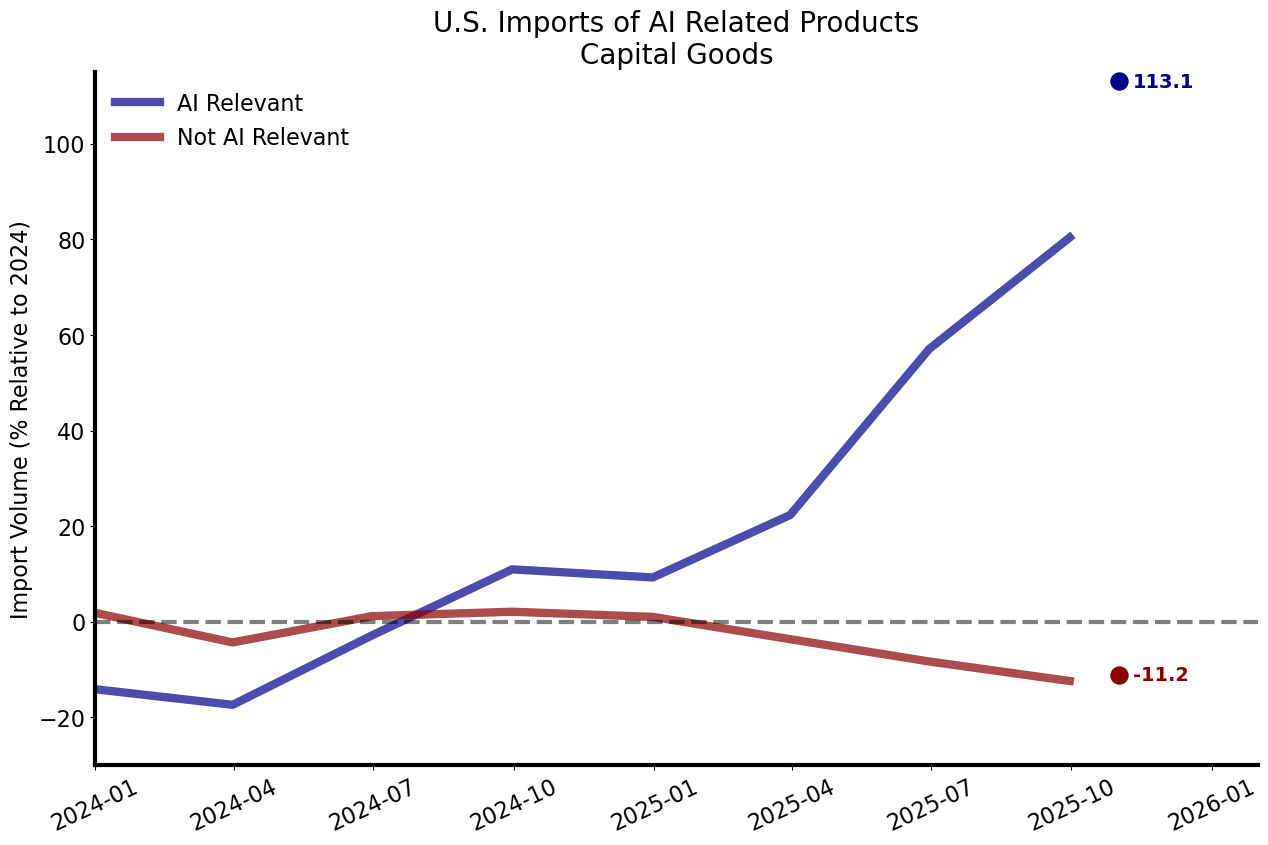

In [157]:
fig, ax = plt.subplots(figsize = (15,9))

# Prepare data for AI Relevant (High)
foo_monthly = grp_sum[grp_sum['relevance']=='High'].copy()
foo_monthly.set_index('time', inplace=True)
foo = foo_monthly.resample('QE').agg({
    'CON_VAL_MO': 'sum'
})
foo_complete = foo.iloc[:-1]

# Prepare data for Aggregate
foo2 = grp_total.copy()
foo2.set_index('time', inplace=True)
foo2 = foo2.resample('QE').agg({
    'CON_VAL_MO': 'sum'
})
foo2_complete = foo2.iloc[:-1]
foo2_last = foo2.iloc[-1]

# Prepare data for Not AI Relevant (Low)
foo3_monthly = grp_sum[grp_sum['relevance']=='Low'].copy()
foo3_monthly.set_index('time', inplace=True)
foo3 = foo3_monthly.resample('QE').agg({
    'CON_VAL_MO': 'sum'
})
foo3_complete = foo3.iloc[:-1]

# Plot AI Relevant (complete quarters)
ax.plot(foo_complete.index, 100*(4*foo_complete["CON_VAL_MO"] / foo["CON_VAL_MO"].loc[index_year].sum() - 1) , 
        color = "darkblue", alpha = 0.7, linewidth = 6, label='AI Relevant')

# Plot AI Relevant November 2025 monthly dot
november_ai_data = foo_monthly[(foo_monthly.index.year == 2025) & (foo_monthly.index.month == 11)].iloc[-1]
november_date = november_ai_data.name
november_ai_value = 100*(12*november_ai_data["CON_VAL_MO"] / foo["CON_VAL_MO"].loc[index_year].sum() - 1)
ax.scatter(november_date, november_ai_value,
           color = "darkblue", s=150, zorder=5)

# # Plot Aggregate (complete quarters)
# ax.plot(foo2_complete.index, 100*(4*foo2_complete["CON_VAL_MO"] / foo2["CON_VAL_MO"].loc[index_year].sum()) ,
#          color = "black", alpha = 0.7, linewidth = 6, label='Aggregate')

# # Plot Aggregate last quarter as dot
# ax.scatter(october_date, 100*(12*foo2_last["CON_VAL_MO"] / foo2["CON_VAL_MO"].loc[index_year].sum()),
#            color = "black", s=150, zorder=5)

# Plot Not AI Relevant (complete quarters)
ax.plot(foo3_complete.index, 100*(4*foo3_complete["CON_VAL_MO"] / foo3["CON_VAL_MO"].loc[index_year].sum() - 1) ,
         color = "darkred", alpha = 0.7, linewidth = 6, label='Not AI Relevant')

# Plot Not AI Relevant November 2025 monthly dot
november_low_data = foo3_monthly[(foo3_monthly.index.year == 2025) & (foo3_monthly.index.month == 11)].iloc[-1]
november_low_value = 100*(12*november_low_data["CON_VAL_MO"] / foo3["CON_VAL_MO"].loc[index_year].sum() - 1)
ax.scatter(november_date, november_low_value,
           color = "darkred", s=150, zorder=5)

ax.set_title("U.S. Imports of AI Related Products\nCapital Goods", fontsize = 20)

ax.set_xlim([dt.datetime(2024,1,1), dt.datetime(2026,1,31)])

ax.set_ylim(-30,115)

ax.axhline(y=0, color='black', linestyle='--', linewidth=3, alpha=0.5)

ax.tick_params(axis='x', labelsize=16, rotation=25)
ax.tick_params(axis='y', labelsize=16)

ax.set_ylabel(f"Import Volume (% Relative to {index_year})", fontsize=16)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)

ax.legend(
    fontsize=16,
    frameon=False,
    loc='upper left',
    ncol=1
)

# Add annotations for November observations
ax.annotate(f'{november_ai_value:.1f}', 
            xy=(november_date, november_ai_value),
            xytext=(10, 0), textcoords='offset points',
            fontsize=14, fontweight='bold', color='darkblue',
            va='center')

# last_value_agg = 100*(12*foo2_last["CON_VAL_MO"] / foo2["CON_VAL_MO"].loc[index_year].sum())
# ax.annotate(f'{last_value_agg:.1f}', 
#             xy=(october_date, last_value_agg),
#             xytext=(10, 0), textcoords='offset points',
#             fontsize=14, fontweight='bold', color='black',
#             va='center')

ax.annotate(f'{november_low_value:.1f}', 
            xy=(november_date, november_low_value),
            xytext=(10, 0), textcoords='offset points',
            fontsize=14, fontweight='bold', color='darkred',
            va='center')

# plt.savefig(figfile+"canada-tariffs.png", bbox_inches = "tight")
# plt.savefig(figfile+"canada-tariffs.pdf", bbox_inches = "tight")

ai_quarterly_export = pd.DataFrame(index=foo_complete.index)
ai_quarterly_export["ai_relevant_CON_VAL_MO"] = foo_complete["CON_VAL_MO"]
ai_quarterly_export["not_ai_relevant_CON_VAL_MO"] = foo3_complete.reindex(foo_complete.index)["CON_VAL_MO"]
ai_quarterly_export.index.name = "time"
ai_quarterly_export.to_csv(output_dir / "ai_capital_goods_quarterly.csv")

ai_monthly_export = pd.DataFrame(index=foo_monthly.index.union(foo3_monthly.index).sort_values())
ai_monthly_export["ai_relevant_CON_VAL_MO"] = foo_monthly.reindex(ai_monthly_export.index)["CON_VAL_MO"]
ai_monthly_export["not_ai_relevant_CON_VAL_MO"] = foo3_monthly.reindex(ai_monthly_export.index)["CON_VAL_MO"]
ai_monthly_export.index.name = "time"
ai_monthly_export.to_csv(output_dir / "ai_capital_goods_monthly.csv")

plt.show()

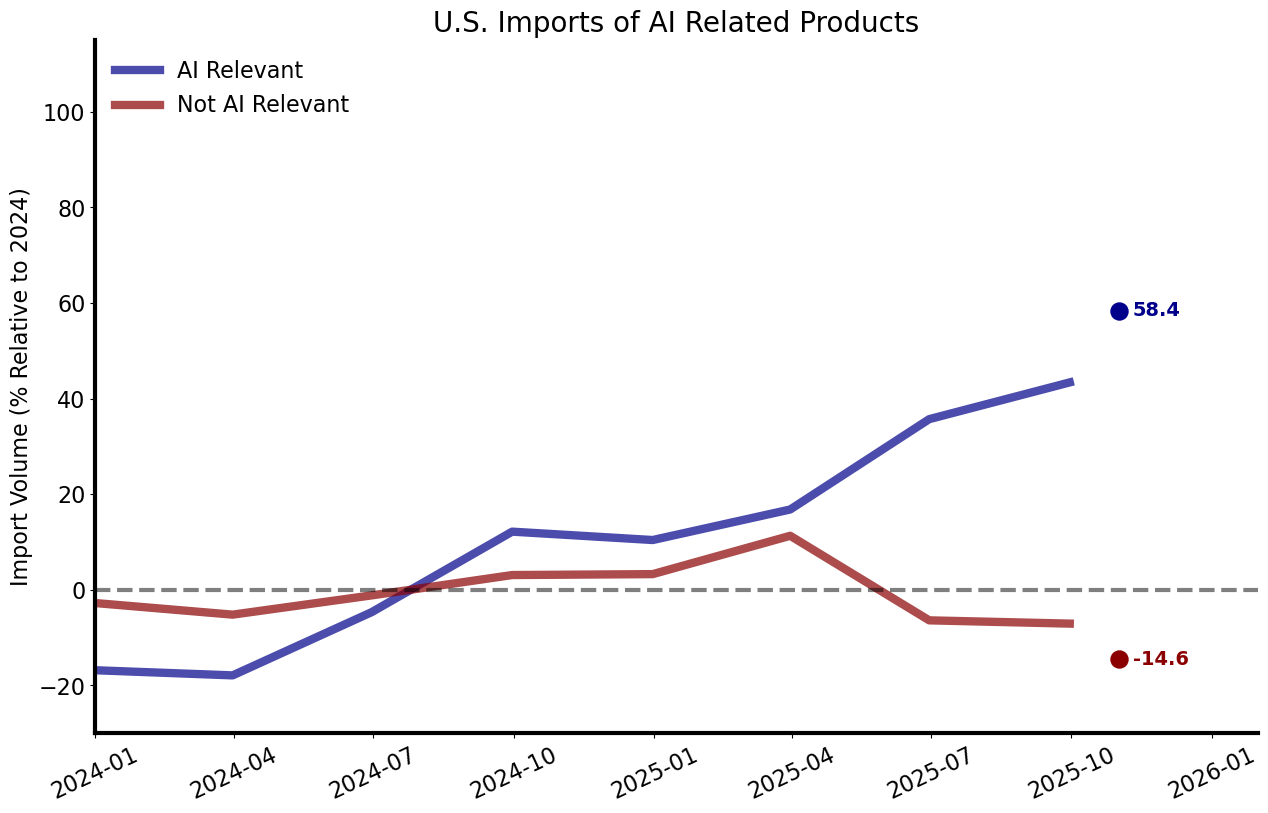

In [158]:
fig, ax = plt.subplots(figsize = (15,9))

# Prepare data for all non-excluded trade
# (not restricted to Capital Goods)
dfsec_all = df[~df["HS2"].isin(excluded_hs2)].copy()

grp_all = dfsec_all.groupby(['relevance', 'time'], observed=False)[['CON_VAL_MO']].sum().reset_index()

# AI Relevant (High)
foo_monthly = grp_all[grp_all['relevance'] == 'High'].copy()
foo_monthly.set_index('time', inplace=True)
foo = foo_monthly.resample('QE').agg({'CON_VAL_MO': 'sum'})
foo_complete = foo.iloc[:-1]

# Not AI Relevant (Low)
foo3_monthly = grp_all[grp_all['relevance'] == 'Low'].copy()
foo3_monthly.set_index('time', inplace=True)
foo3 = foo3_monthly.resample('QE').agg({'CON_VAL_MO': 'sum'})
foo3_complete = foo3.iloc[:-1]

# Plot AI Relevant (complete quarters)
ax.plot(
    foo_complete.index,
    100*(4*foo_complete["CON_VAL_MO"] / foo["CON_VAL_MO"].loc[index_year].sum() - 1),
    color="darkblue", alpha=0.7, linewidth=6, label='AI Relevant'
)

# Plot AI Relevant November 2025 monthly dot
november_ai_data = foo_monthly[(foo_monthly.index.year == 2025) & (foo_monthly.index.month == 11)].iloc[-1]
november_date = november_ai_data.name
november_ai_value = 100*(12*november_ai_data["CON_VAL_MO"] / foo["CON_VAL_MO"].loc[index_year].sum() - 1)
ax.scatter(november_date, november_ai_value, color="darkblue", s=150, zorder=5)

# Plot Not AI Relevant (complete quarters)
ax.plot(
    foo3_complete.index,
    100*(4*foo3_complete["CON_VAL_MO"] / foo3["CON_VAL_MO"].loc[index_year].sum() - 1),
    color="darkred", alpha=0.7, linewidth=6, label='Not AI Relevant'
)

# Plot Not AI Relevant November 2025 monthly dot
november_low_data = foo3_monthly[(foo3_monthly.index.year == 2025) & (foo3_monthly.index.month == 11)].iloc[-1]
november_low_value = 100*(12*november_low_data["CON_VAL_MO"] / foo3["CON_VAL_MO"].loc[index_year].sum() - 1)
ax.scatter(november_date, november_low_value, color="darkred", s=150, zorder=5)

ax.set_title("U.S. Imports of AI Related Products", fontsize=20)

ax.set_xlim([dt.datetime(2024,1,1), dt.datetime(2026,1,31)])
ax.set_ylim(-30,115)

ax.axhline(y=0, color='black', linestyle='--', linewidth=3, alpha=0.5)

ax.tick_params(axis='x', labelsize=16, rotation=25)
ax.tick_params(axis='y', labelsize=16)

ax.set_ylabel(f"Import Volume (% Relative to {index_year})", fontsize=16)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)

ax.legend(fontsize=16, frameon=False, loc='upper left', ncol=1)

# Add annotations for November observations
ax.annotate(
    f'{november_ai_value:.1f}',
    xy=(november_date, november_ai_value),
    xytext=(10, 0), textcoords='offset points',
    fontsize=14, fontweight='bold', color='darkblue', va='center'
)

ax.annotate(
    f'{november_low_value:.1f}',
    xy=(november_date, november_low_value),
    xytext=(10, 0), textcoords='offset points',
    fontsize=14, fontweight='bold', color='darkred', va='center'
)

ai_quarterly_export = pd.DataFrame(index=foo_complete.index)
ai_quarterly_export["ai_relevant_CON_VAL_MO"] = foo_complete["CON_VAL_MO"]
ai_quarterly_export["not_ai_relevant_CON_VAL_MO"] = foo3_complete.reindex(foo_complete.index)["CON_VAL_MO"]
ai_quarterly_export.index.name = "time"
ai_quarterly_export.to_csv(output_dir / "ai_nonexcluded_quarterly.csv")

ai_monthly_export = pd.DataFrame(index=foo_monthly.index.union(foo3_monthly.index).sort_values())
ai_monthly_export["ai_relevant_CON_VAL_MO"] = foo_monthly.reindex(ai_monthly_export.index)["CON_VAL_MO"]
ai_monthly_export["not_ai_relevant_CON_VAL_MO"] = foo3_monthly.reindex(ai_monthly_export.index)["CON_VAL_MO"]
ai_monthly_export.index.name = "time"
ai_monthly_export.to_csv(output_dir / "ai_nonexcluded_monthly.csv")

plt.show()

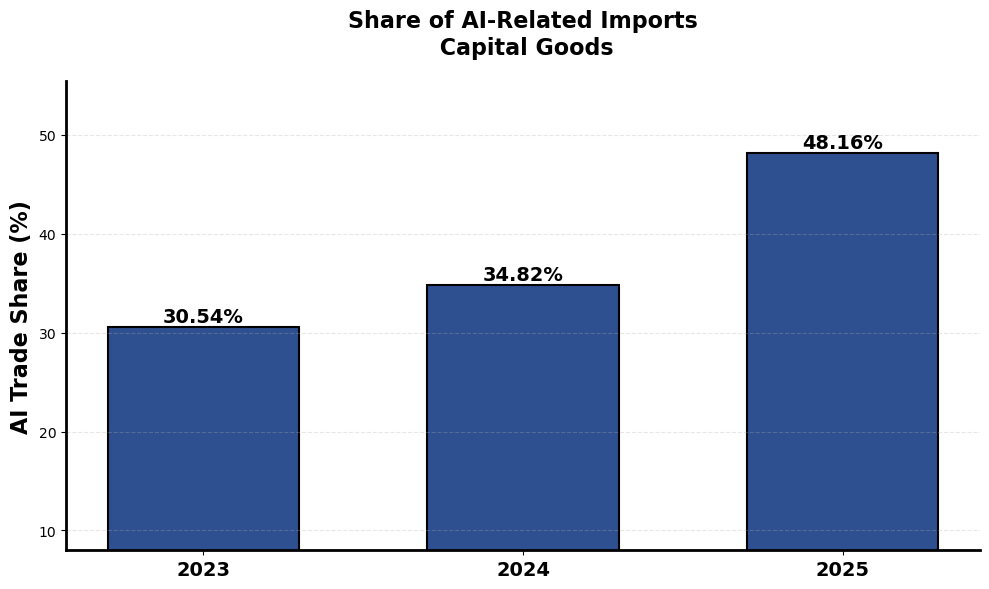


AI Trade Share:
  2023: 30.54%
  2024: 34.82%
  2025: 48.16%

Growth: 17.63 percentage points


In [159]:
# Calculate AI trade share for each year (2023-2025)
years = [2023, 2024, 2025]
ai_shares = []

foo = grp_sum[grp_sum['relevance']=='High'].copy()
foo.set_index("time", inplace=True)
dfsec.set_index("time", inplace=True)

for year in years:
    year_str = str(year)
    total_trade = dfsec.CON_VAL_MO.loc[year_str].sum()
    ai_trade = foo.CON_VAL_MO.loc[year_str].sum()
    ai_share = (ai_trade / total_trade) * 100
    ai_shares.append(ai_share)

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(years, ai_shares, color='#2E5090', edgecolor='black', linewidth=1.5, width=0.6)

# Add value labels on bars
for i, (year, share) in enumerate(zip(years, ai_shares)):
    ax.text(year, share + 0.1, f'{share:.2f}%', 
            ha='center', va='bottom', fontsize=14, fontweight='bold')

# Formatting
# ax.set_xlabel('Year', fontsize=16, fontweight='bold')
ax.set_ylabel('AI Trade Share (%)', fontsize=16, fontweight='bold')
ax.set_title('Share of AI-Related Imports\n Capital Goods', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(years)
ax.set_ylim(8, max(ai_shares) * 1.15)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Make x-tick labels bold and larger
ax.tick_params(axis='x', labelsize=14)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)

plt.tight_layout()
plt.show()

print(f"\nAI Trade Share:")
for year, share in zip(years, ai_shares):
    print(f"  {year}: {share:.2f}%")
print(f"\nGrowth: {ai_shares[-1] - ai_shares[0]:.2f} percentage points")

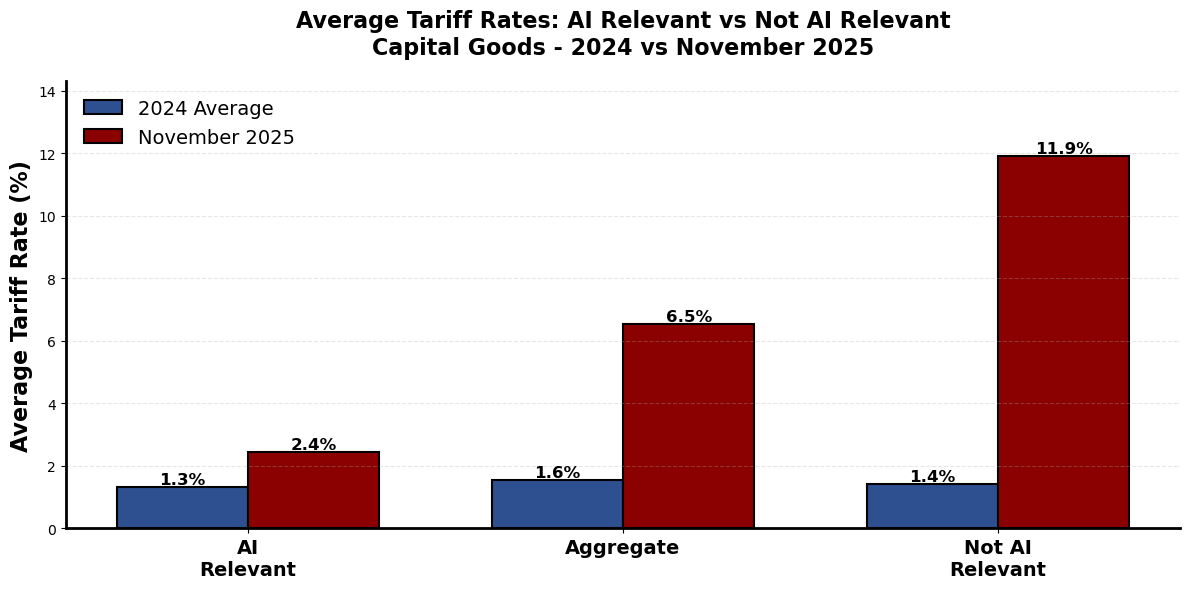


Average Tariff Rates (Capital Goods):
  AI Relevant:
    2024 Average: 1.32%
    November 2025: 2.45%
    Change: 1.12 percentage points
  Aggregate:
    2024 Average: 1.56%
    November 2025: 6.55%
    Change: 4.99 percentage points
  Not AI Relevant:
    2024 Average: 1.43%
    November 2025: 11.92%
    Change: 10.49 percentage points


In [160]:
# Average tariff rates: AI Relevant vs Not AI Relevant - 2024 vs November 2025

# Reset index if time is currently the index
dfsec_temp = dfsec.reset_index() if dfsec.index.name == 'time' else dfsec.copy()

# Calculate tariff rates for AI Relevant (High)
df_ai = dfsec_temp[dfsec_temp['relevance'] == 'High']
tariff_ai_2024 = 100 * df_ai[df_ai['time'].dt.year == 2024]['CAL_DUT_MO'].sum() / df_ai[df_ai['time'].dt.year == 2024]['CON_VAL_MO'].sum()
tariff_ai_nov2025 = 100 * df_ai[(df_ai['time'].dt.year == 2025) & (df_ai['time'].dt.month == 11)]['CAL_DUT_MO'].sum() / df_ai[(df_ai['time'].dt.year == 2025) & (df_ai['time'].dt.month == 11)]['CON_VAL_MO'].sum()

# Calculate tariff rates for Aggregate (all dfsec)
tariff_agg_2024 = 100 * dfsec_temp[dfsec_temp['time'].dt.year == 2024]['CAL_DUT_MO'].sum() / dfsec_temp[dfsec_temp['time'].dt.year == 2024]['CON_VAL_MO'].sum()
tariff_agg_nov2025 = 100 * dfsec_temp[(dfsec_temp['time'].dt.year == 2025) & (dfsec_temp['time'].dt.month == 11)]['CAL_DUT_MO'].sum() / dfsec_temp[(dfsec_temp['time'].dt.year == 2025) & (dfsec_temp['time'].dt.month == 11)]['CON_VAL_MO'].sum()

# Calculate tariff rates for Not AI Relevant (Low)
df_low = dfsec_temp[dfsec_temp['relevance'] == 'Low']
tariff_low_2024 = 100 * df_low[df_low['time'].dt.year == 2024]['CAL_DUT_MO'].sum() / df_low[df_low['time'].dt.year == 2024]['CON_VAL_MO'].sum()
tariff_low_nov2025 = 100 * df_low[(df_low['time'].dt.year == 2025) & (df_low['time'].dt.month == 11)]['CAL_DUT_MO'].sum() / df_low[(df_low['time'].dt.year == 2025) & (df_low['time'].dt.month == 11)]['CON_VAL_MO'].sum()

category_labels = ["AI\nRelevant", "Aggregate", "Not AI\nRelevant"]
tariff_2024 = [tariff_ai_2024, tariff_agg_2024, tariff_low_2024]
tariff_nov2025 = [tariff_ai_nov2025, tariff_agg_nov2025, tariff_low_nov2025]

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(category_labels))
width = 0.35

bars1 = ax.bar(x - width/2, tariff_2024, width, label='2024 Average', 
               color='#2E5090', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, tariff_nov2025, width, label='November 2025',
               color='darkred', edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Formatting
ax.set_ylabel('Average Tariff Rate (%)', fontsize=16, fontweight='bold')
ax.set_title('Average Tariff Rates: AI Relevant vs Not AI Relevant\nCapital Goods - 2024 vs November 2025', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(category_labels)
ax.legend(fontsize=14, frameon=False, loc='upper left')
ax.set_ylim(0, max(max(tariff_2024), max(tariff_nov2025)) * 1.2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Make x-tick labels bold and larger
ax.tick_params(axis='x', labelsize=14)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)

plt.tight_layout()
plt.show()

print(f"\nAverage Tariff Rates (Capital Goods):")
for label, t2024, tnov2025 in zip(["AI Relevant", "Aggregate", "Not AI Relevant"], 
                                   tariff_2024, tariff_nov2025):
    print(f"  {label}:")
    print(f"    2024 Average: {t2024:.2f}%")
    print(f"    November 2025: {tnov2025:.2f}%")
    print(f"    Change: {tnov2025 - t2024:.2f} percentage points")